In [2]:
##import libraries
import os
import cv2 as cv
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

*loading the dataset*

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("antoreepjana/animals-detection-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 8.92G/8.92G [01:16<00:00, 125MB/s]

Extracting model files...


Path to dataset files: /root/.cache/kagglehub/datasets/antoreepjana/animals-detection-images-dataset/versions/7


In [4]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

class CustomDataset(Dataset):
    def __init__(self, root, data, augmented=False, transformations=None):
        if data == "train" and augmented:
            data_dir = "train"
        else:
            data_dir = {
                "train": "train",
                "test": "test"
            }[data]

        data_path = os.path.join(root, data_dir)

        # Check if "images" subdirectory exists; adjust the path accordingly
        images_path = os.path.join(data_path, "images")
        if os.path.exists(images_path):
            data_path = images_path

        self.transformations = transformations

        # Get all image paths
        self.im_paths = sorted(glob(os.path.join(data_path, "*", "*.*")))

        # Raise an error if no images are found
        if len(self.im_paths) == 0:
            raise ValueError(f"No images found in {data_path}. Please check the dataset path.")

        # Build class mappings
        self.cls_names = {}
        self.cls_counts = {}
        count = 0
        for im_path in self.im_paths:
            class_name = os.path.basename(os.path.dirname(im_path))
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        class_name = os.path.basename(os.path.dirname(im_path))
        gt = self.cls_names[class_name]
        if self.transformations:
            im = self.transformations(im)
        return im, gt

def get_dls(root, transformations, bs, augmented=True, ns=4):
    tr_ds = CustomDataset(root=root, data="train", augmented=augmented, transformations=transformations)

    ts_ds = CustomDataset(root=root, data="test", transformations=transformations)

    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)

    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)

    return tr_dl, ts_dl, tr_ds.cls_names

# Define the root path
root = "/root/.cache/kagglehub/datasets/antoreepjana/animals-detection-images-dataset/versions/7/"

# Define transformations
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
tfs = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Get data loaders
tr_dl, ts_dl, classes = get_dls(root=root, augmented=True, transformations=tfs, bs=64)

# Print information
print(f"Number of training batches: {len(tr_dl)}")

print(f"Number of test batches: {len(ts_dl)}")
print(f"Classes: {classes}")


Number of training batches: 353
Number of test batches: 6505
Classes: {'Bear': 0, 'Brown bear': 1, 'Bull': 2, 'Butterfly': 3, 'Camel': 4, 'Canary': 5, 'Caterpillar': 6, 'Cattle': 7, 'Centipede': 8, 'Cheetah': 9, 'Chicken': 10, 'Crab': 11, 'Crocodile': 12, 'Deer': 13, 'Duck': 14, 'Eagle': 15, 'Elephant': 16, 'Fish': 17, 'Fox': 18, 'Frog': 19, 'Giraffe': 20, 'Goat': 21, 'Goldfish': 22, 'Goose': 23, 'Hamster': 24, 'Harbor seal': 25, 'Hedgehog': 26, 'Hippopotamus': 27, 'Horse': 28, 'Jaguar': 29, 'Jellyfish': 30, 'Kangaroo': 31, 'Koala': 32, 'Ladybug': 33, 'Leopard': 34, 'Lion': 35, 'Lizard': 36, 'Lynx': 37, 'Magpie': 38, 'Monkey': 39, 'Moths and butterflies': 40, 'Mouse': 41, 'Mule': 42, 'Ostrich': 43, 'Otter': 44, 'Owl': 45, 'Panda': 46, 'Parrot': 47, 'Penguin': 48, 'Pig': 49, 'Polar bear': 50, 'Rabbit': 51, 'Raccoon': 52, 'Raven': 53, 'Red panda': 54, 'Rhinoceros': 55, 'Scorpion': 56, 'Sea lion': 57, 'Sea turtle': 58, 'Seahorse': 59, 'Shark': 60, 'Sheep': 61, 'Shrimp': 62, 'Snail': 63, '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


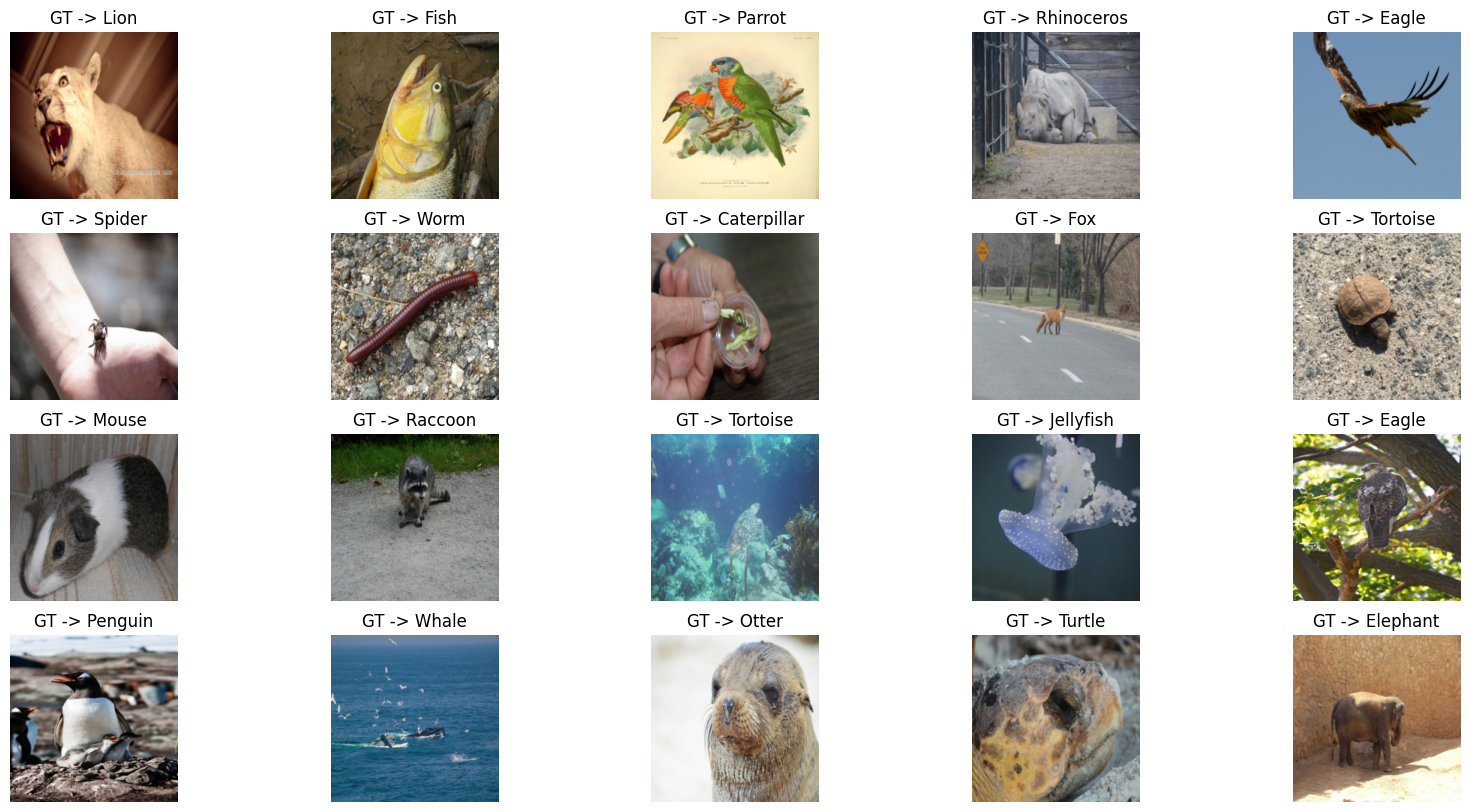

In [5]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [6]:
val_dl=tr_dl

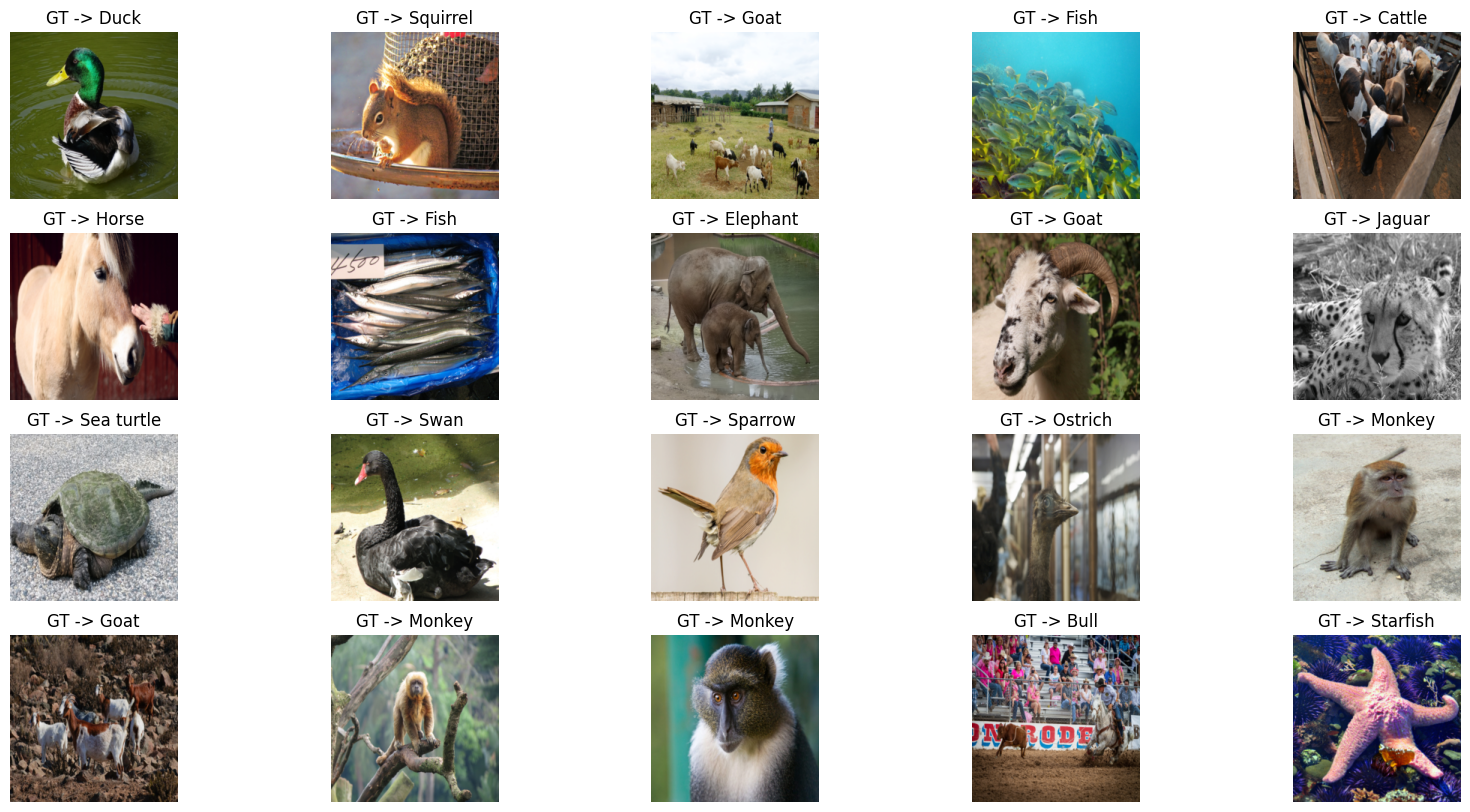

In [7]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [12]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.0 MB/s eta 0:00:00


In [13]:
import timm
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))
def train_setup(m): return m.to("cuda"), 1, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item()

m, epochs, device, loss_fn, optimizer = train_setup(m)

save_prefix, save_dir = "animals", "saved_models"
print("Start training...")
best_acc, best_loss, threshold = 0, float("inf"), 0.01
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc = 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = m(ims)
            loss = loss_fn(preds, gts)
            pred_cls = torch.argmax(preds.data, dim = 1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
353it [05:53,  1.00s/it]

1-epoch train process is completed!
1-epoch train loss          -> 0.886
1-epoch train accuracy      -> 0.762


1-epoch validation process is completed!
1-epoch validation loss     -> 0.257
1-epoch validation accuracy -> 0.912


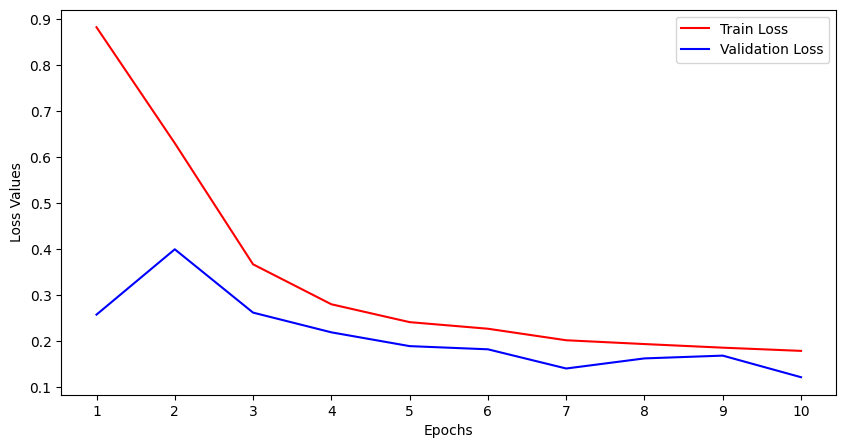

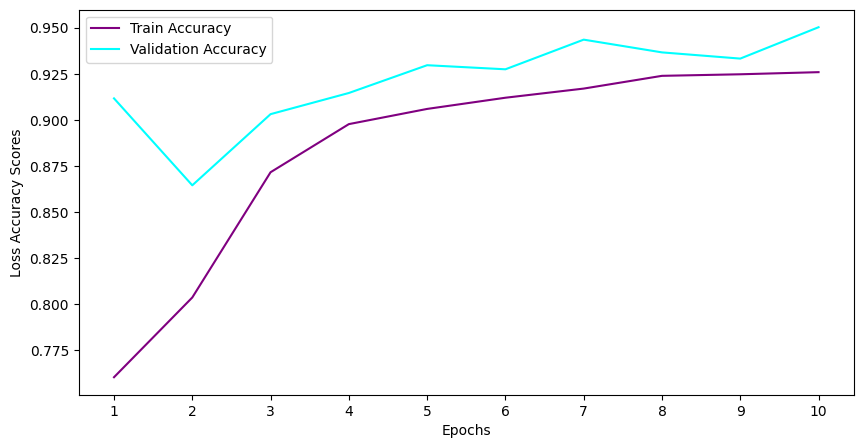

In [ ]:
def learning_curves(tr_losses, val_losses, tr_accs, val_accs):

    plt.figure(figsize = (10, 5))
    plt.plot(tr_losses, label = "Train Loss", c = "red")
    plt.plot(val_losses, label = "Validation Loss", c = "blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()

    plt.figure(figsize = (10, 5))
    plt.plot(tr_accs, label = "Train Accuracy", c = "purple")
    plt.plot(val_accs, label = "Validation Accuracy", c = "cyan")
    plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()

learning_curves(tr_losses, val_losses, tr_accs, val_accs)

<ipython-input-24-59a8b1244ea5>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
/usr/local/lib/py

Accuracy of the model on the test data -> 0.806


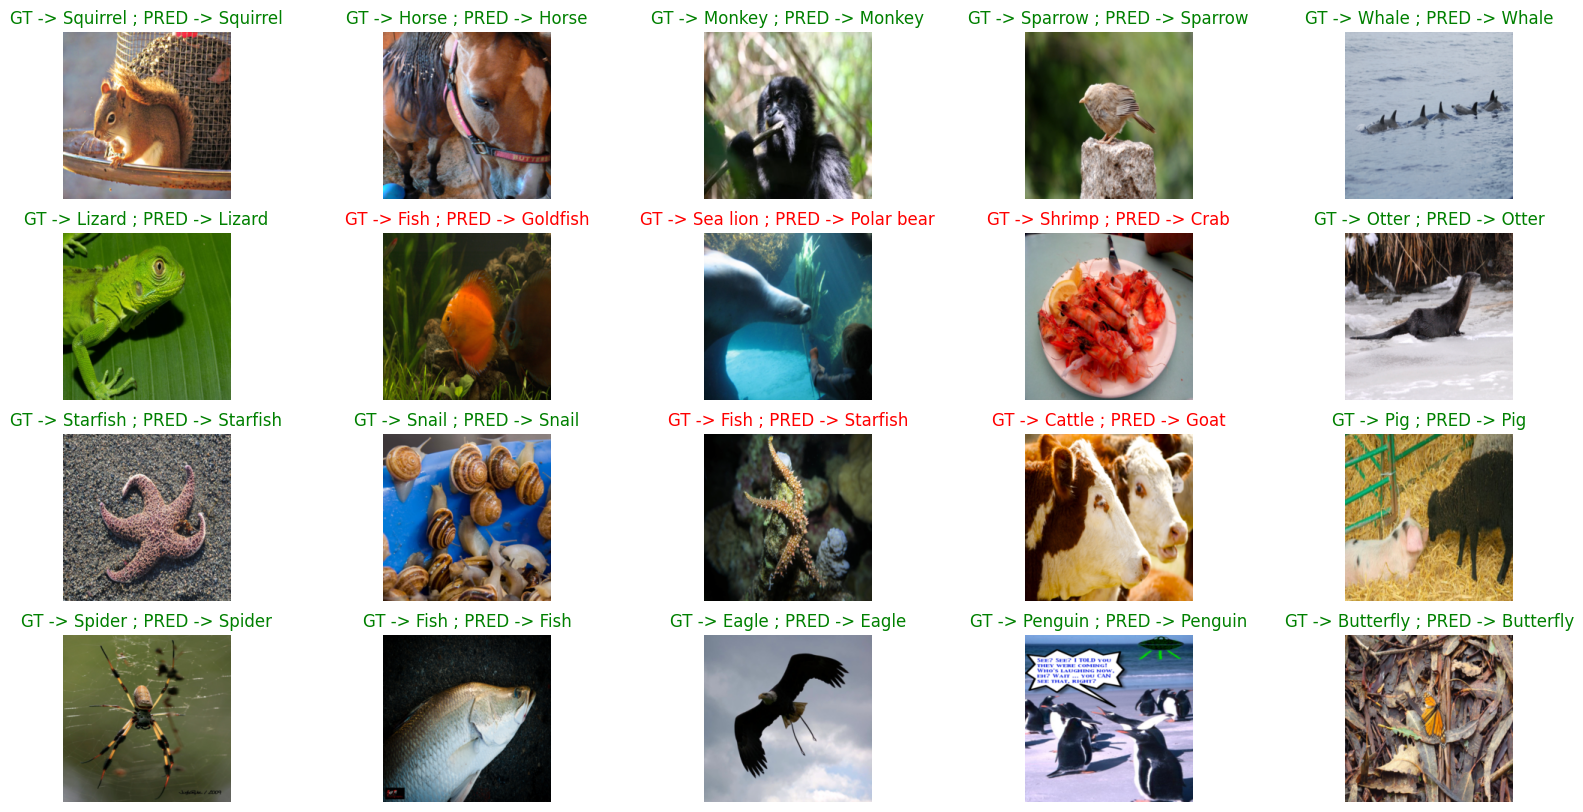

In [24]:
def inference(model, device, test_dl, num_ims, row, cls_names = None):

    acc = 0
    preds, images, lbls = [], [], []
    for idx, data in enumerate(test_dl):
        im, gt = data
        im, gt = im.to(device), gt.to(device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
inference(m.to(device), device, ts_dl, 20, 4, list(classes.keys()))

In [23]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the pre-trained model
model = torch.load('/content/saved_models/animals_best_model.pth')
# Load the model onto the GPU
m1 = timm.create_model("rexnet_150", pretrained = False, num_classes = len(classes)) # Create a new model instance with the same architecture but not pretrained
m1.load_state_dict(model) #Load the saved weights
m1.eval()
m1.to("cuda") #Move the model to the GPU


# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match the input size of the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization parameters (mean)
                         std=[0.229, 0.224, 0.225])    # Normalization parameters (std)
])

# Function to process the image
def process_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
    image = transform(image)  # Apply the transformations
    image = image.unsqueeze(0)  # Add a batch dimension
    # Move the image to the GPU
    image = image.to("cuda")
    return image

# Prompt the user for an image path
image_path = input("/content/download (1).jpeg")

# Process the input image
input_tensor = process_image(image_path)

# Run the model on the input tensor
with torch.no_grad():
    output = m1(input_tensor)

# Obtain the predicted class
_, predicted = torch.max(output, 1)
class_names=list(classes)
predicted_class_name = class_names[predicted.item()]
print(f"Predicted class: {predicted.item()}")
print("The animal is :",predicted_class_name)

<ipython-input-23-6b36a9b1d96d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/saved_models/animals_best_model.pth')


/content/download (1).jpeg/content/download (1).jpeg
Predicted class: 68
The animal is : Squirrel
